In [1]:
# Import the required Libraries

import sklearn, os
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Some display options

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# Let's pick one file to work with (Part-00000) for easy computation

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/part-00000-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv')
len(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238687 entries, 0 to 238686
Data columns (total 47 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   flow_duration    238687 non-null  float64
 1   Header_Length    238687 non-null  float64
 2   Protocol Type    238687 non-null  float64
 3   Duration         238687 non-null  float64
 4   Rate             238687 non-null  float64
 5   Srate            238687 non-null  float64
 6   Drate            238687 non-null  float64
 7   fin_flag_number  238687 non-null  int64  
 8   syn_flag_number  238687 non-null  int64  
 9   rst_flag_number  238687 non-null  int64  
 10  psh_flag_number  238687 non-null  int64  
 11  ack_flag_number  238687 non-null  int64  
 12  ece_flag_number  238687 non-null  int64  
 13  cwr_flag_number  238687 non-null  int64  
 14  ack_count        238687 non-null  float64
 15  syn_count        238687 non-null  float64
 16  fin_count        238687 non-null  floa

In [5]:
# df.head(40)
df.loc[2215,:]

,2215
flow_duration,0.317407
Header_Length,22056.0
Protocol Type,17.0
Duration,64.0
Rate,1375.42088
Srate,1375.42088
Drate,0.0
fin_flag_number,0
syn_flag_number,0
rst_flag_number,0


In [6]:
# Next we Standardize the data

from sklearn.preprocessing import StandardScaler, RobustScaler

features = df.drop('label', axis=1)
scaler = StandardScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
scaled_df = pd.concat([scaled_features, df['label']], axis=1)

del df

scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238687 entries, 0 to 238686
Data columns (total 47 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   flow_duration    238687 non-null  float64
 1   Header_Length    238687 non-null  float64
 2   Protocol Type    238687 non-null  float64
 3   Duration         238687 non-null  float64
 4   Rate             238687 non-null  float64
 5   Srate            238687 non-null  float64
 6   Drate            238687 non-null  float64
 7   fin_flag_number  238687 non-null  float64
 8   syn_flag_number  238687 non-null  float64
 9   rst_flag_number  238687 non-null  float64
 10  psh_flag_number  238687 non-null  float64
 11  ack_flag_number  238687 non-null  float64
 12  ece_flag_number  238687 non-null  float64
 13  cwr_flag_number  238687 non-null  float64
 14  ack_count        238687 non-null  float64
 15  syn_count        238687 non-null  float64
 16  fin_count        238687 non-null  floa

In [7]:
scaled_df.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,cwr_flag_number,ack_count,syn_count,fin_count,urg_count,rst_count,HTTP,HTTPS,DNS,Telnet,SMTP,SSH,IRC,TCP,UDP,DHCP,ARP,ICMP,IPv,LLC,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Magnitude,Radius,Covariance,Variance,Weight,label
0,-0.018025,-0.167425,-0.342900,-0.167212,-0.093112,-0.093112,-0.003051,3.24907,-0.509564,3.167323,-0.312084,-0.377524,0.0,0.0,3.174414,-0.497105,2.851804,-0.086776,-0.119045,-0.22729,-0.241397,-0.012946,0.0,0.0,-0.006789,0.0,0.860678,-0.519352,0.0,-0.008922,-0.44125,0.011936,0.011936,-0.284364,-0.269827,-0.241942,-0.293315,-0.205885,-0.291610,0.011200,0.003291,-0.317348,-0.205716,-0.071405,-0.414431,0.003297,DDoS-RSTFINFlood
1,-0.018025,-0.167418,-0.305831,-0.167212,-0.093072,-0.093072,-0.003051,-0.30778,-0.509564,-0.315724,-0.312084,-0.377524,0.0,0.0,-0.316124,-0.497105,-0.314440,-0.086776,-0.119045,4.39967,-0.241397,-0.012946,0.0,0.0,-0.006789,0.0,0.860678,-0.519352,0.0,-0.008922,-0.44125,0.011936,0.011936,-0.278904,-0.269827,-0.218805,-0.290033,-0.188656,-0.279191,-0.013219,0.003291,-0.308990,-0.188409,-0.071046,-0.200851,0.003297,DoS-TCP_Flood
2,-0.018025,-0.167542,-0.904559,-0.167212,-0.092784,-0.092784,-0.003051,-0.30778,-0.509564,-0.315724,-0.312084,-0.377524,0.0,0.0,-0.316124,-0.497105,-0.314440,-0.086776,-0.119045,-0.22729,-0.241397,-0.012946,0.0,0.0,-0.006789,0.0,-1.161874,-0.519352,0.0,-0.008922,2.26629,0.011936,0.011936,-0.332366,-0.355547,-0.264514,-0.342766,-0.205885,-0.340632,-0.001416,0.003291,-0.459093,-0.205716,-0.071405,-0.414431,0.003297,DDoS-ICMP_Flood
3,-0.017024,-0.001817,0.892748,-0.167212,-0.047055,-0.047055,-0.003051,-0.30778,-0.509564,-0.315724,-0.312084,-0.377524,0.0,0.0,-0.316124,-0.497105,-0.314440,-0.086776,-0.119045,-0.22729,-0.241397,-0.012946,0.0,0.0,-0.006789,0.0,-1.161874,1.925476,0.0,-0.008922,-0.44125,0.011936,0.011936,-0.300364,-0.298400,-0.249466,-0.309799,-0.205885,-0.307950,-0.007980,0.003291,-0.362662,-0.205716,-0.071405,-0.414431,0.003297,DoS-UDP_Flood
4,-0.017667,-0.167321,-0.330544,-0.031029,-0.093053,-0.093053,-0.003051,-0.30778,1.962464,-0.315724,-0.312084,-0.377524,0.0,0.0,-0.316124,1.030204,-0.187790,-0.086776,-0.118983,-0.22729,-0.241397,-0.012946,0.0,0.0,-0.006789,0.0,0.860678,-0.519352,0.0,-0.008922,-0.44125,0.011936,0.011936,-0.254800,-0.242111,-0.095973,-0.235789,-0.064825,-0.275759,-0.010476,0.003291,-0.207089,-0.064525,-0.064669,0.397172,0.003297,DoS-SYN_Flood


In [8]:
scaled_df

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,cwr_flag_number,ack_count,syn_count,fin_count,urg_count,rst_count,HTTP,HTTPS,DNS,Telnet,SMTP,SSH,IRC,TCP,UDP,DHCP,ARP,ICMP,IPv,LLC,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Magnitude,Radius,Covariance,Variance,Weight,label
0,-0.018025,-0.167425,-0.342900,-0.167212,-0.093112,-0.093112,-0.003051,3.24907,-0.509564,3.167323,-0.312084,-0.377524,0.0,0.0,3.174414,-0.497105,2.851804,-0.086776,-0.119045,-0.22729,-0.241397,-0.012946,0.0,0.0,-0.006789,0.0,0.860678,-0.519352,0.0,-0.008922,-0.44125,0.011936,0.011936,-0.284364,-0.269827,-0.241942,-0.293315,-0.205885,-0.291610,0.011200,0.003291,-0.317348,-0.205716,-0.071405,-0.414431,0.003297,DDoS-RSTFINFlood
1,-0.018025,-0.167418,-0.305831,-0.167212,-0.093072,-0.093072,-0.003051,-0.30778,-0.509564,-0.315724,-0.312084,-0.377524,0.0,0.0,-0.316124,-0.497105,-0.314440,-0.086776,-0.119045,4.39967,-0.241397,-0.012946,0.0,0.0,-0.006789,0.0,0.860678,-0.519352,0.0,-0.008922,-0.44125,0.011936,0.011936,-0.278904,-0.269827,-0.218805,-0.290033,-0.188656,-0.279191,-0.013219,0.003291,-0.308990,-0.188409,-0.071046,-0.200851,0.003297,DoS-TCP_Flood
2,-0.018025,-0.167542,-0.904559,-0.167212,-0.092784,-0.092784,-0.003051,-0.30778,-0.509564,-0.315724,-0.312084,-0.377524,0.0,0.0,-0.316124,-0.497105,-0.314440,-0.086776,-0.119045,-0.22729,-0.241397,-0.012946,0.0,0.0,-0.006789,0.0,-1.161874,-0.519352,0.0,-0.008922,2.26629,0.011936,0.011936,-0.332366,-0.355547,-0.264514,-0.342766,-0.205885,-0.340632,-0.001416,0.003291,-0.459093,-0.205716,-0.071405,-0.414431,0.003297,DDoS-ICMP_Flood
3,-0.017024,-0.001817,0.892748,-0.167212,-0.047055,-0.047055,-0.003051,-0.30778,-0.509564,-0.315724,-0.312084,-0.377524,0.0,0.0,-0.316124,-0.497105,-0.314440,-0.086776,-0.119045,-0.22729,-0.241397,-0.012946,0.0,0.0,-0.006789,0.0,-1.161874,1.925476,0.0,-0.008922,-0.44125,0.011936,0.011936,-0.300364,-0.298400,-0.249466,-0.309799,-0.205885,-0.307950,-0.007980,0.003291,-0.362662,-0.205716,-0.071405,-0.414431,0.003297,DoS-UDP_Flood
4,-0.017667,-0.167321,-0.330544,-0.031029,-0.093053,-0.093053,-0.003051,-0.30778,1.962464,-0.315724,-0.312084,-0.377524,0.0,0.0,-0.316124,1.030204,-0.187790,-0.086776,-0.118983,-0.22729,-0.241397,-0.012946,0.0,0.0,-0.006789,0.0,0.860678,-0.519352,0.0,-0.008922,-0.44125,0.011936,0.011936,-0.254800,-0.242111,-0.095973,-0.235789,-0.064825,-0.275759,-0.010476,0.003291,-0.207089,-0.064525,-0.064669,0.397172,0.003297,DoS-SYN_Flood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238682,-0.018025,-0.167425,-0.342900,-0.167212,-0.093085,-0.093085,-0.003051,3.24907,-0.509564,3.167323,-0.312084,-0.377524,0.0,0.0,3.174414,-0.497105,2.851804,-0.086776,-0.119045,-0.22729,-0.241397,-0.012946,0.0,0.0,-0.006789,0.0,0.860678,-0.519352,0.0,-0.008922,-0.44125,0.011936,0.011936,-0.284364,-0.269827,-0.241942,-0.293315,-0.205885,-0.291610,0.011239,0.003291,-0.317348,-0.205716,-0.071405,-0.414431,0.003297,DDoS-RSTFINFlood
238683,-0.018025,-0.167425,-0.342900,-0.167212,-0.091295,-0.091295,-0.003051,-0.30778,-0.509564,-0.315724,3.204267,2.648841,0.0,0.0,-0.316124,-0.497105,-0.314440,-0.073035,-0.115925,-0.22729,-0.241397,-0.012946,0.0,0.0,-0.006789,0.0,0.860678,-0.519352,0.0,-0.008922,-0.44125,0.011936,0.011936,-0.284364,-0.269827,-0.241942,-0.293315,-0.205885,-0.291610,0.009452,0.003291,-0.317348,-0.205716,-0.071405,-0.414431,0.003297,DDoS-PSHACK_Flood
238684,-0.018023,-0.167420,-0.330544,-0.167212,-0.090069,-0.090069,-0.003051,-0.30778,1.962464,-0.315724,-0.312084,-0.377524,0.0,0.0,-0.316124,0.999960,-0.314440,-0.086776,-0.119045,-0.22729,-0.241397,-0.012946,0.0,0.0,-0.006789,0.0,0.860678,-0.519352,0.0,-0.008922,-0.44125,0.011936,0.011936,-0.284124,-0.269827,-0.240757,-0.293178,-0.205026,-0.290752,-0.003705,0.003291,-0.316975,-0.20485

In [9]:
# Checking for Missing values

#Note: No missing values found

scaled_df.isnull().sum()


,0
flow_duration,0
Header_Length,0
Protocol Type,0
Duration,0
Rate,0
Srate,0
Drate,0
fin_flag_number,0
syn_flag_number,0
rst_flag_number,0


In [10]:
# To display the label value counts

# 34 labels in general

scaled_df["label"].value_counts()

,count
label,
DDoS-ICMP_Flood,36554
DDoS-UDP_Flood,27626
DDoS-TCP_Flood,23149
DDoS-PSHACK_Flood,21210
DDoS-SYN_Flood,20739
DDoS-RSTFINFlood,20669
DDoS-SynonymousIP_Flood,18189
DoS-UDP_Flood,16957
DoS-TCP_Flood,13630


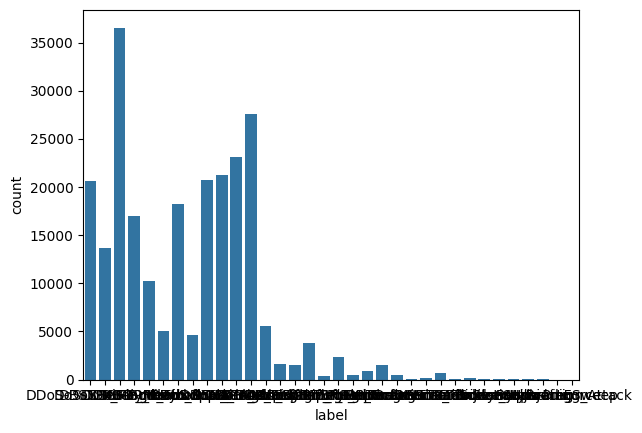

In [11]:
# Plot the label value count

import seaborn as sns
sns.countplot(data=scaled_df, x="label")
plt.show()

In [12]:
# Describe the dataset to get the mean, STD, 25th, 50th and 75th percentiles

scaled_df.describe()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,cwr_flag_number,ack_count,syn_count,fin_count,urg_count,rst_count,HTTP,HTTPS,DNS,Telnet,SMTP,SSH,IRC,TCP,UDP,DHCP,ARP,ICMP,IPv,LLC,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Magnitude,Radius,Covariance,Variance,Weight
count,2.386870e+05,2.386870e+05,2.386870e+05,2.386870e+05,2.386870e+05,2.386870e+05,2.386870e+05,2.386870e+05,2.386870e+05,2.386870e+05,2.386870e+05,2.386870e+05,238687.0,238687.0,2.386870e+05,2.386870e+05,2.386870e+05,2.386870e+05,2.386870e+05,2.386870e+05,2.386870e+05,2.386870e+05,238687.0,238687.0,2.386870e+05,238687.0,2.386870e+05,2.386870e+05,238687.0,2.386870e+05,2.386870e+05,2.386870e+05,2.386870e+05,2.386870e+05,2.386870e+05,2.386870e+05,2.386870e+05,2.386870e+05,2.386870e+05,2.386870e+05,2.386870e+05,2.386870e+05,2.386870e+05,2.386870e+05,2.386870e+05,2.386870e+05
mean,-1.912646e-18,-6.683097e-18,-1.295985e-16,3.773196e-17,9.883244e-18,9.883244e-18,1.674495e-18,-1.935717e-17,-4.679657e-17,-9.761192e-17,-4.596304e-17,1.271128e-17,0.0,0.0,-3.431599e-17,-2.023088e-16,3.061722e-17,2.205869e-17,5.646399e-17,-3.290942e-17,-9.317637e-17,7.293358e-19,0.0,0.0,3.334106e-18,0.0,4.387922e-17,-1.911157e-17,0.0,-8.930642e-19,-4.917807e-17,-1.951643e-15,-1.951643e-15,-4.911853e-17,-1.699055e-17,1.359541e-16,-1.329177e-17,2.563094e-17,6.309499e-17,2.927316e-16,9.785454e-16,1.010502e-16,-2.171635e-17,-7.099861e-18,-4.030697e-17,1.199132e-15
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,0.0,0.0,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,0.0,0.0,1.000002e+00,0.0,1.000002e+00,1.000002e+00,0.0,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-1.802532e-02,-1.675421e-01,-1.016891e+00,-4.730409e+00,-9.311503e-02,-9.311503e-02,-3.051005e-03,-3.077804e-01,-5.095636e-01,-3.157240e-01,-3.120839e-01,-3.775237e-01,0.0,0.0,-3.161239e-01,-4.971046e-01,-3.144402e-01,-8.677563e-02,-1.190454e-01,-2.272897e-01,-2.413969e-01,-1.294649e-02,0.0,0.0,-6.788784e-03,0.0,-1.161874e+00,-5.193520e-01,0.0,-8.922359e-03,-4.412498e-01,-8.378070e+01,-8.378070e+01,-4.843738e-01,-3.555471e-01,-2.645141e-01,-3.427665e-01,-2.058847e-01,-3.406315e-01,-4.860359e+00,-1.033957e+01,-4.590932e-01,-2.057163e-01,-7.140548e-02,-4.144312e-01,-6.646053e+00
25%,-1.802532e-02,-1.674247e-01,-3.429005e-01,-1.672118e-01,-9.309427e-02,-9.309427e-02,-3.051005e-03,-3.077804e-01,-5.095636e-01,-3.157240e-01,-3.120839e-01,-3.775237e-01,0.0,0.0,-3.161239e-01,-4.971046e-01,-3.144402e-01,-8.677563e-02,-1.190454e-01,-2.272897e-01,-2.413969e-01,-1.294649e-02,0.0,0.0,-6.788784e-03,0.0,-1.161874e+00,-5.193520e-01,0.0,-8.922359e-03,-4.412498e-01,1.193592e-02,1.193592e-02,-3.003645e-01,-2.984004e-01,-2.494658e-01,-3.097987e-01,-2.058847e-01,-3.079503e-01,-4.714214e-03,3.291182e-03,-3.626623e-01,-2.057163e-01,-7.140548e-02,-4.144312e-01,3.297124e-03
50%,-1.802532e-02,-1.674247e-01,-3.429005e-01,-1.672118e-01,-9.295787e-02,-9.295787e-02,-3.051005e-03,-3.077804e-01,-5.095636e-01,-3.157240e-01,-3.120839e-01,-3.775237e-01,0.0,0.0,-3.161239e-01,-4.971046e-01,-3.144402e-01,-8.677563e-02,-1.190454e-01,-2.272897e-01,-2.413969e-01,-1.294649e-02,0.0,0.0,-6.788784e-03,0.0,8.606782e-01,-5.193520e-01,0.0,-8.922359e-03,-4.412498e-01,1.193592e-02,1.193592e-02,-2.843636e-01,-2.698271e-01,-2.419416e-01,-2.933149e-01,-2.058847e-01,-2.916097e-01,-1.619137e-03,3.291182e-03,-3.173483e-01,-2.057163e-01,-7.140548e-02,-4.144312e-01,3.297124e-03
75%,-1.770643e-02,-1.668092e-01,5.692331e-01,-1.672118e-01,-9.193283e-02,-9.193283e-02,-3.051005e-03,-3.077804e-01,-5.095636e-01,-3.157240e-01,-3.120839e-01,-3.77

In [13]:
# Remapping the 34 Labels into 8 Labels with similar attack-classes

remap_labels = {
    'DDoS-RSTFINFlood': 'DDoS',
    'DDoS-PSHACK_Flood': 'DDoS',
    'DDoS-SYN_Flood': 'DDoS',
    'DDoS-UDP_Flood': 'DDoS',
    'DDoS-TCP_Flood': 'DDoS',
    'DDoS-ICMP_Flood': 'DDoS',
    'DDoS-SynonymousIP_Flood': 'DDoS',
    'DDoS-ACK_Fragmentation': 'DDoS',
    'DDoS-UDP_Fragmentation': 'DDoS',
    'DDoS-ICMP_Fragmentation': 'DDoS',
    'DDoS-SlowLoris': 'DDoS',
    'DDoS-HTTP_Flood': 'DDoS',
    'DoS-UDP_Flood': 'DoS',
    'DoS-SYN_Flood': 'DoS',
    'DoS-TCP_Flood': 'DoS',
    'DoS-HTTP_Flood': 'DoS',
    'Mirai-greeth_flood': 'Mirai',
    'Mirai-greip_flood': 'Mirai',
    'Mirai-udpplain': 'Mirai',
    'Recon-PingSweep': 'Recon',
    'Recon-OSScan': 'Recon',
    'Recon-PortScan': 'Recon',
    'VulnerabilityScan': 'Recon',
    'Recon-HostDiscovery': 'Recon',
    'DNS_Spoofing': 'Spoofing',
    'MITM-ArpSpoofing': 'Spoofing',
    'BenignTraffic': 'Benign',
    'BrowserHijacking': 'Web',
    'Backdoor_Malware': 'Web',
    'XSS': 'Web',
    'Uploading_Attack': 'Web',
    'SqlInjection': 'Web',
    'CommandInjection': 'Web',
    'DictionaryBruteForce': 'BruteForce'
}

scaled_df['label'] = scaled_df['label'].apply(lambda x : remap_labels[x])

scaled_df['label'].value_counts()

,count
label,
DDoS,173777
DoS,41276
Mirai,13435
Benign,5600
Spoofing,2539
Recon,1860
Web,137
BruteForce,63


In [14]:
# Dataset is imbalanced. Picking n samples from each class in a crude attempt to balance it.

n = 1000

# Taking n samples from each class
sampled_df = scaled_df.groupby('label', group_keys=False).apply(lambda x: x.head(n))

sampled_df.value_counts('label')

,count
label,
Benign,1000
DDoS,1000
DoS,1000
Mirai,1000
Recon,1000
Spoofing,1000
Web,137
BruteForce,63


In [15]:
# Separating features and labels
X = sampled_df.drop('label', axis=1)
y = sampled_df['label']

# Apply SMOTE Technique to the training data
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new DataFrame with the resampled dataset
resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
resampled_df['label'] = y_resampled

resampled_df.value_counts('label')

,count
label,
Benign,1000
BruteForce,1000
DDoS,1000
DoS,1000
Mirai,1000
Recon,1000
Spoofing,1000
Web,1000


In [16]:
# Carry out 'Label Encoding' to remap categorical labels to numerics

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
resampled_df['label'] = label_encoder.fit_transform(resampled_df['label'])

resampled_df.value_counts('label')

,count
label,
0,1000
1,1000
2,1000
3,1000
4,1000
5,1000
6,1000
7,1000


In [17]:
# Re-describe the resampled dataset

resampled_df.describe()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,cwr_flag_number,ack_count,syn_count,fin_count,urg_count,rst_count,HTTP,HTTPS,DNS,Telnet,SMTP,SSH,IRC,TCP,UDP,DHCP,ARP,ICMP,IPv,LLC,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Magnitude,Radius,Covariance,Variance,Weight,label
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8.000000e+03,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.0,8000.0,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.0,8000.0,8000.000000,8000.0,8000.000000,8000.000000,8000.0,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,0.286029,0.722679,0.306637,1.364873,-0.058383,-0.058383,-3.051005e-03,-0.252205,-0.309947,-0.207314,-0.173137,0.955802,0.0,0.0,-0.103411,0.323904,-0.141327,0.862414,0.882043,-0.058979,0.896465,0.214488,0.0,0.0,3.639099,0.0,0.069285,-0.024342,0.0,0.047121,-0.365439,-0.111209,-0.111209,0.957851,0.615163,1.120196,1.002826,1.062984,0.997429,-0.034246,-0.042880,1.076490,1.062068,0.415497,2.003934,-0.042996,3.500000
std,2.837005,2.404318,1.239177,2.656256,0.396745,0.396745,8.674160e-19,0.441147,0.673548,0.604888,0.655728,1.491140,0.0,0.0,0.646113,1.072090,0.949438,3.317083,2.747046,0.854255,1.906548,3.981025,0.0,0.0,22.887627,0.0,0.978380,0.971300,0.0,2.505869,0.446698,3.050055,3.050055,2.156264,2.071871,2.351737,2.108864,2.355089,2.106586,3.805897,3.801504,1.698172,2.356005,2.247396,1.865356,3.807776,2.291431
min,-0.018025,-0.167542,-0.909052,-4.587809,-0.093115,-0.093115,-3.051005e-03,-0.307780,-0.509564,-0.315724,-0.312084,-0.377524,0.0,0.0,-0.316124,-0.497105,-0.314440,-0.086776,-0.119045,-0.227290,-0.241397,-0.012946,0.0,0.0,-0.006789,0.0,-1.161874,-0.519352,0.0,-0.008922,-0.441250,-83.780701,-83.780701,-0.388598,-0.355547,-0.264514,-0.342766,-0.205885,-0.340632,-4.860359,-4.863939,-0.459093,-0.205716,-0.071405,-0.414431,-4.871947,0.000000
25%,-0.017913,-0.167307,-0.342900,-0.167212,-0.093059,-0.093059,-3.051005e-03,-0.307780,-0.509564,-0.315724,-0.312084,-0.377524,0.0,0.0,-0.316124,-0.497105,-0.314440,-0.086776,-0.119045,-0.227290,-0.241397,-0.012946,0.0,0.0,-0.006789,0.0,-1.161874,-0.519352,0.0,-0.008922,-0.441250,0.011936,0.011936,-0.284364,-0.269827,-0.219369,-0.277896,-0.205885,-0.276903,-4.860359,-4.863939,-0.278203,-0.205716,-0.071405,-0.414431,-4.871947,1.750000
50%,-0.003839,-0.140646,-0.219336,-0.037040,-0.092790,-0.092790,-3.051005e-03,-0.307780,-0.509564,-0.315724,-0.312084,-0.377524,0.0,0.0,-0.316124,-0.345886,-0.314440,-0.048407,-0.090648,-0.227290,-0.241397,-0.012946,0.0,0.0,-0.006789,0.0,0.860678,-0.519352,0.0,-0.008922,-0.441250,0.011936,0.011936,0.049653,-0.226967,0.215249,0.004856,0.057162,-0.011278,-0.000142,0.003291,0.302137,0.055665,-0.064819,3.156928,0.003297,3.500000
75%,0.151729,0.100611,0.454655,2.135114,-0.091978,-0.091978,-3.051005e-03,-0.307780,-0.509564,-0.315724,-0.312084,2.648841,0.0,0.0,-0.316124,1.015082,-0.314440,0.501173,0.388198,-0.227290,4.142556,-0.012946,0.0,0.0,-0.006789,0.0,0.860678,-0.519352,0.0,-0.008922,-0.441250,0.011936,0.011936,1.715738,-0.004487,1.196440,1.767169,1.152305,1.750966,4.872870,4.870522,2.327109,1.146500,0.093194,3.857165,4.878541,5.250000
max,181.451082,21.174345,4.262700,13.451080,14.472846,14.472846,-3.051005e-03,3.249070,1.962464,3.167323,3.204267,2.648841,0.0,0.0,7.363059,5.551643,61.427320,40.569177,25.043632,4.399670,4.142556,77.241019,0.0,0.0,147.301793,0.0,0.860678,1.925476,0.0,112.077980,2.266290,0.011936,0.011936,21.737326,20.217248,36.551137,25.526218,43.672207,23.418605,4.938391,4.870522,10.860607,43.673662,132.303687,3.857165,4.878541,7.000000


In [18]:
# Check the Skewness of the dataset

resampled_df.skew()

,0
flow_duration,47.000656
Header_Length,4.241799
Protocol Type,2.421568
Duration,2.066376
Rate,23.497356
Srate,23.497356
Drate,0.000000
fin_flag_number,7.812731
syn_flag_number,3.078197
rst_flag_number,5.401072


In [19]:
# Split dataset into "Train set" and "Test set" on 80/20 ratio

X_train, X_test, y_train, y_test = train_test_split(resampled_df.drop('label', axis=1), resampled_df['label'], test_size=0.2, random_state=42)

In [20]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6400, 46)
(1600, 46)
(6400,)
(1600,)


In [21]:
# Definition of the performance metrics (Accuracy, Recall, Precision and F1-score)

def get_perf_metrics(y_pred, y_test):
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_pred, y_test, average='macro')
    precision = precision_score(y_pred, y_test, average='macro')
    f1 = f1_score(y_pred, y_test, average='macro')

    return [accuracy, recall, precision, f1]

            Feature  Importance
39              IAT    0.149793
41        Magnitude    0.059082
1     Header_Length    0.057537
18        rst_count    0.053055
0     flow_duration    0.050046
36              AVG    0.048281
35              Max    0.046676
38         Tot size    0.045409
2     Protocol Type    0.043475
34              Min    0.042576
17        urg_count    0.039361
4              Rate    0.032713
33          Tot sum    0.032571
5             Srate    0.031524
44         Variance    0.031455
42           Radius    0.030426
15        syn_count    0.025846
3          Duration    0.024825
37              Std    0.023315
43       Covariance    0.022012
45           Weight    0.014212
16        fin_count    0.013343
40           Number    0.012667
24              SSH    0.011030
11  ack_flag_number    0.009854
20            HTTPS    0.009504
14        ack_count    0.009012
26              TCP    0.008770
27              UDP    0.005793
10  psh_flag_number    0.004081
19      

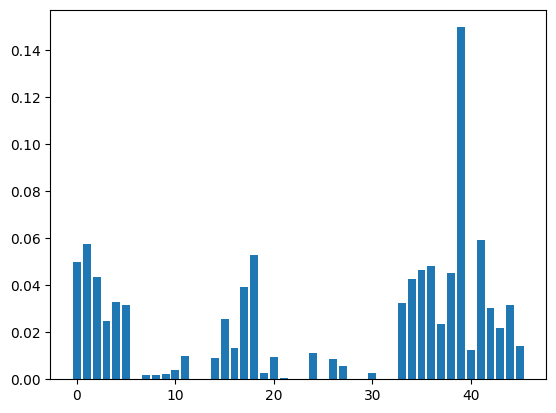

[Accuracy, Recall, Precision, F1 Score]
[0.915625, 0.9165225158228907, 0.9158666958453788, 0.914595371494527]


In [22]:
# Experiment 1 - the Random Forest (RF) Algorithm exploration


rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Getting the feature importances
rf_feature_importances = rf_model.feature_importances_

# Create a DataFrame to display feature importances
importances_random_forest_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf_feature_importances})
print(importances_random_forest_df.sort_values(by='Importance', ascending=False))

plt.bar(range(len(rf_feature_importances)), rf_feature_importances)
plt.show()

# Make predictions on the test-set
rf_y_pred = rf_model.predict(X_test)

# Calculate the performance metrics
rf_metrics = get_perf_metrics(rf_y_pred, y_test)

print("[Accuracy, Recall, Precision, F1 Score]")
print(rf_metrics)

Score:  91.5625


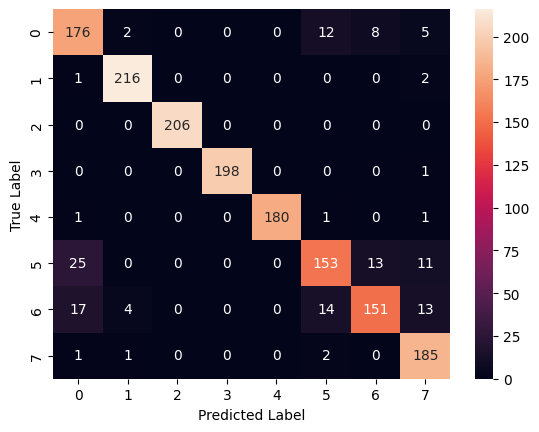

In [23]:
# Display the Confusion Matrix and Accuracy Score in Percentage of RF

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score

score = accuracy_score(y_test, rf_y_pred)
print("Score: ", score*100)
cm = confusion_matrix(y_test, rf_y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


            Feature  Coefficient
0     flow_duration    -3.059746
18        rst_count     1.979764
1     Header_Length    -1.231427
44         Variance     0.853209
11  ack_flag_number     0.693627
26              TCP    -0.644971
10  psh_flag_number    -0.630477
35              Max     0.597197
43       Covariance     0.548260
37              Std    -0.518873
42           Radius    -0.475101
19             HTTP    -0.444963
41        Magnitude    -0.367441
2     Protocol Type     0.358982
5             Srate     0.339702
4              Rate     0.339702
7   fin_flag_number     0.302845
8   syn_flag_number    -0.288108
24              SSH    -0.287414
39              IAT    -0.276691
27              UDP    -0.229592
36              AVG     0.227271
29              ARP     0.226442
17        urg_count     0.221660
9   rst_flag_number    -0.189555
30             ICMP     0.155138
14        ack_count     0.118472
3          Duration     0.094551
33          Tot sum     0.090628
45        

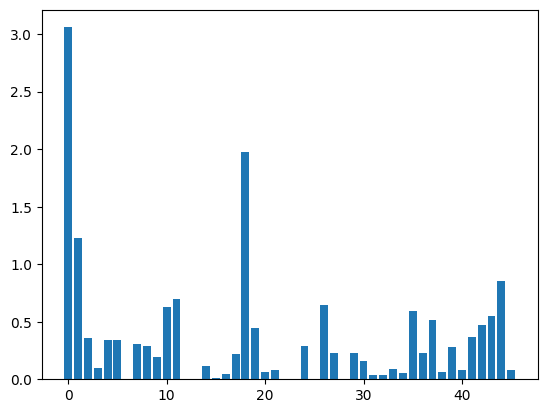

[Accuracy, Recall, Precision, F1 Score]
[0.668125, 0.6978580521510306, 0.673207729269137, 0.6662828653020878]


In [24]:
# Experiment 2 - the Logistic Regression (LR) Algorithm exploration


logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train, y_train)

# Get feature coefficients
feature_coefficients = logreg_model.coef_[0]

# Create a DataFrame to display feature coefficients
lr_importances_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': feature_coefficients})
lr_importances_df.sort_values(by='Coefficient', key=lambda x: abs(x), ascending=False, inplace=True)
print(lr_importances_df)

feature_coefficients_abs = np.abs(feature_coefficients)
plt.bar(range(len(feature_coefficients)), feature_coefficients_abs)
plt.show()

# Make predictions on the test set
lr_y_pred = logreg_model.predict(X_test)

# Calculate performance metrics
lr_metrics = get_perf_metrics(lr_y_pred, y_test)

print("[Accuracy, Recall, Precision, F1 Score]")
print(lr_metrics)

Score:  66.8125


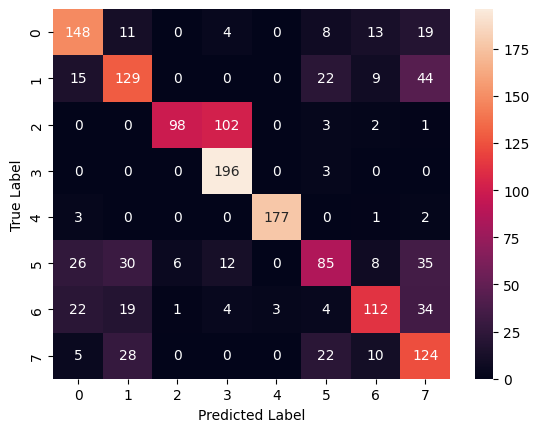

In [25]:
# Confusion Matrix and Accuracy score of LR

score = accuracy_score(y_test, lr_y_pred)
print("Score: ", score*100)
cm = confusion_matrix(y_test, lr_y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

            Feature  Importance
41        Magnitude    0.186254
24              SSH    0.123004
39              IAT    0.086109
40           Number    0.069066
30             ICMP    0.068296
16        fin_count    0.055645
34              Min    0.048497
18        rst_count    0.041360
44         Variance    0.034069
8   syn_flag_number    0.022981
31              IPv    0.021900
1     Header_Length    0.020627
9   rst_flag_number    0.019936
26              TCP    0.017725
0     flow_duration    0.017690
15        syn_count    0.015608
19             HTTP    0.014012
11  ack_flag_number    0.013727
10  psh_flag_number    0.012363
2     Protocol Type    0.011697
14        ack_count    0.010240
33          Tot sum    0.010002
21              DNS    0.008927
38         Tot size    0.008049
17        urg_count    0.007772
27              UDP    0.007330
4              Rate    0.007195
3          Duration    0.007118
20            HTTPS    0.006958
42           Radius    0.006827
35      

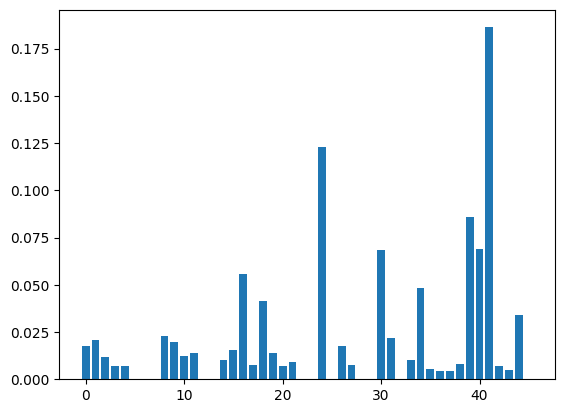

[Accuracy, Recall, Precision, F1 Score]
[0.933125, 0.9327619466448837, 0.9333901173720702, 0.9328985925606075]


In [26]:
# Experiment 3 - the Extreme Gradient Boost (XGBoost) Algorithm exploration


import xgboost as xgb

xg_model = xgb.XGBClassifier()
xg_model.fit(X_train, y_train)

# Get feature importances
xg_feature_importances = xg_model.feature_importances_

# Create a DataFrame to display feature importances
importances_xg_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': xg_feature_importances})
print(importances_xg_df.sort_values(by='Importance', ascending=False))

plt.bar(range(len(xg_feature_importances)), xg_feature_importances)
plt.show()

# Make predictions on the test set
xg_y_pred = xg_model.predict(X_test)

# Calculate performance metrics
xg_metrics = get_perf_metrics(xg_y_pred, y_test)

print("[Accuracy, Recall, Precision, F1 Score]")
print(xg_metrics)


Score:  93.3125


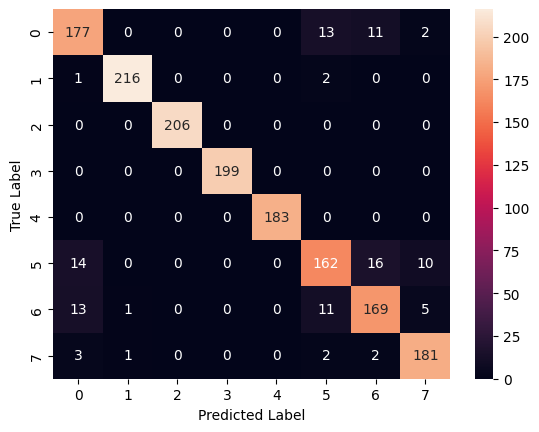

In [27]:
# Display the confusion matric and accuracy score of XGBoost

score = accuracy_score(y_test, xg_y_pred)
print("Score: ", score*100)
cm = confusion_matrix(y_test, xg_y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

            Feature   Coefficient
0     flow_duration -3.619367e+00
18        rst_count  2.353399e+00
41        Magnitude  1.783108e+00
2     Protocol Type  1.682759e+00
37              Std -1.573957e+00
43       Covariance  1.522144e+00
26              TCP  1.246521e+00
35              Max  1.093261e+00
36              AVG -9.474227e-01
4              Rate  8.176214e-01
5             Srate  8.176214e-01
17        urg_count -7.486118e-01
10  psh_flag_number -7.150243e-01
11  ack_flag_number -6.108517e-01
34              Min -5.858940e-01
16        fin_count -5.855042e-01
42           Radius -4.045087e-01
15        syn_count -3.806809e-01
39              IAT -3.765633e-01
27              UDP -3.334186e-01
19             HTTP -2.477938e-01
44         Variance -1.816556e-01
45           Weight  1.772934e-01
40           Number  1.770020e-01
38         Tot size -1.069363e-01
1     Header_Length  6.830118e-02
3          Duration  6.111418e-02
29              ARP  3.681652e-02
14        ack_

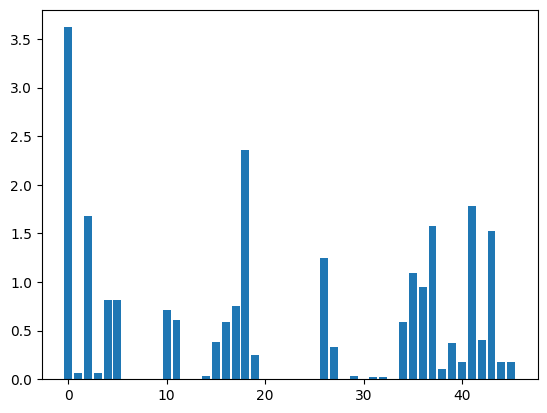

[Accuracy, Recall, Precision, F1 Score]
[0.7125, 0.7493630624050244, 0.715945811216134, 0.7079198488394086]


In [28]:
# Experiment 4 - the Support Vector Machine (SVM) Algorithm exploration


from sklearn import svm

svm_model = svm.SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Get feature coefficients
svm_feature_coefficients = svm_model.coef_[0]

# Create a DataFrame to display feature coefficients
svm_importances_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': svm_feature_coefficients})
svm_importances_df.sort_values(by='Coefficient', key=lambda x: abs(x), ascending=False, inplace=True)
print(svm_importances_df)

svm_feature_coefficients_abs = np.abs(svm_feature_coefficients)

plt.bar(range(len(svm_feature_coefficients)), svm_feature_coefficients_abs)
plt.show()

# Make predictions on the test set
svm_y_pred = svm_model.predict(X_test)

# Calculate performance metrics
svm_metrics = get_perf_metrics(svm_y_pred, y_test)

print("[Accuracy, Recall, Precision, F1 Score]")
print(svm_metrics)

Score:  71.25


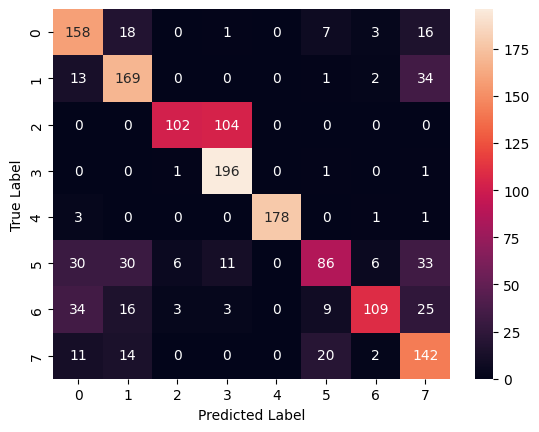

In [29]:
# Display the confusion matrix and Accuracy score of SVM

score = accuracy_score(y_test, svm_y_pred)
print("Score: ", score*100)
cm = confusion_matrix(y_test, svm_y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [30]:
# Import the Stacking Classifier

from sklearn.ensemble import RandomForestClassifier, StackingClassifier

In [31]:
# Define the base models for Experiment 5 (Stacking SVM + XGBoost)

from sklearn.svm import SVC
from xgboost import XGBClassifier

base_models = [
    ('svm', SVC(probability=True, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
]

# Define the meta-model
meta_model = RandomForestClassifier(random_state=42)

In [32]:
# Define the stacking ensemble
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

In [33]:
# Train the stacked model of Experiment 5
stacked_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:34:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:34:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:34:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:34:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:34:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

StackingClassifier(cv=5,
                   estimators=[('svm', SVC(probability=True, random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              imp...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...))],
                   final_estimator=RandomForestClassifier(random_state=42))

In [34]:
# Evaluation of Experiment 5
y_pred = stacked_model.predict(X_test)
y_pred_prob = stacked_model.predict_proba(X_test)[:, 1]

In [35]:
# Define Performance Metrics for the Stacking Classier

def get_perf_metrics(y_pred, y_test):
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_pred, y_test, average='macro')
    precision = precision_score(y_pred, y_test, average='macro')
    f1 = f1_score(y_pred, y_test, average='macro')

    return [accuracy, recall, precision, f1]

In [36]:

# Calculation of the performance metrics for Experiment 5

stacked_model_metrics = get_perf_metrics(y_pred, y_test)

print("[Accuracy, Recall, Precision, F1 Score]")
print(stacked_model_metrics)

[Accuracy, Recall, Precision, F1 Score]
[0.933125, 0.9333011029852283, 0.9333134309208502, 0.9329785233407784]


Score:  93.3125


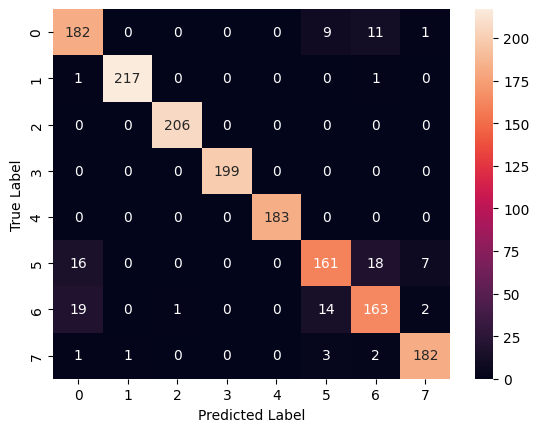

In [37]:
# Display confusion matrix and Accuracy score of Experiment 5

score = accuracy_score(y_test, y_pred)
print("Score: ", score*100)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [39]:
# Define the base models for our Proposed Model, Stacking (RF + XGBoost => RF)

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

base_models = [
    ('RF', RandomForestClassifier(random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
]

# Define the meta-model, that is RF classifier
meta_model = RandomForestClassifier(random_state=42)

In [40]:
# Define the stacking ensemble
RFstacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

In [41]:
# Train the stacked model
RFstacked_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:36:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:36:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:36:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:36:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:36:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

StackingClassifier(cv=5,
                   estimators=[('RF', RandomForestClassifier(random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              im...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...))],
                   final_estimator=RandomForestClassifier(random_state=42))

In [42]:
# Save the model to a file
import joblib

joblib_file = "RFstack_model.pkl"

joblib.dump(RFstacked_model, 'RFstacked_model.pkl')

['RFstacked_model.pkl']

In [43]:

# Load the model from the file

loaded_stacked_model = joblib.load('RFstacked_model.pkl')

In [44]:
# Evaluate the model
y_pred = RFstacked_model.predict(X_test)
y_pred_prob = RFstacked_model.predict_proba(X_test)[:, 1]

In [45]:
# Calculate performance metrics
RFstacked_model_metrics = get_perf_metrics(y_pred, y_test)

print("[Accuracy, Recall, Precision, F1 Score]")
print(RFstacked_model_metrics)

[Accuracy, Recall, Precision, F1 Score]
[0.933125, 0.9328613749415815, 0.9332259193848362, 0.9329846202883714]


Score:  93.3125


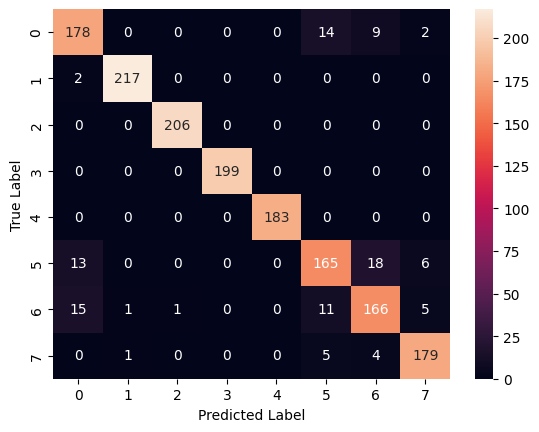

In [46]:
# Display the confusion matrix and Acuuracy score of our proposed model

score = accuracy_score(y_test, y_pred)
print("Score: ", score*100)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

joblib_file = "/content/drive/My Drive/Mirai/RFstack_model.pkl"
joblib.dump(RFstacked_model, 'RFstacked_model.pkl')


Mounted at /content/drive/


['new_mirai_stacked_model.pkl']

In [47]:
'''
1. import the file
2. dataframe
3. Preprocess
3. iterate over the rows of the table and generate a prediction (positive or false) label DDoS

'''

'\n1. import the file\n2. dataframe\n3. Preprocess\n3. iterate over the rows of the table and generate a prediction (positive or false) label DDoS\n\n'

In [48]:
prediction= RFstacked_model.predict(X_test)
prediction

array([3, 3, 2, ..., 2, 7, 1])

In [49]:
# Load the new dataset
new_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/extracted_simulated_attack.csv')

In [50]:
# Load the new dataset
new_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/extracted_simulated_attack.csv')

In [51]:
new_data.head()



,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,cwr_flag_number,ack_count,syn_count,fin_count,urg_count,rst_count,HTTP,HTTPS,DNS,Telnet,SMTP,SSH,IRC,TCP,UDP,DHCP,ARP,ICMP,IPv,LLC,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Magnitude,Radius,Covariance,Variance,Weight,label
0,42,42,UDP,2024-07-16 23:01:32.534815,42,42,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,42,42,UDP,2024-07-16 23:01:32.549799,42,42,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,42,42,UDP,2024-07-16 23:01:32.562424,42,42,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,42,42,UDP,2024-07-16 23:01:32.573952,42,42,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,203,203,UDP,2024-07-16 23:01:32.578432,203,203,203,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [52]:
# Replace 'UDP' with 17 in the 'Protocol Type' column
new_data['Protocol Type'] = new_data['Protocol Type'].replace('UDP', 17.00)

In [53]:
new_data.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,cwr_flag_number,ack_count,syn_count,fin_count,urg_count,rst_count,HTTP,HTTPS,DNS,Telnet,SMTP,SSH,IRC,TCP,UDP,DHCP,ARP,ICMP,IPv,LLC,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Magnitude,Radius,Covariance,Variance,Weight,label
0,42,42,17.0,2024-07-16 23:01:32.534815,42,42,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,42,42,17.0,2024-07-16 23:01:32.549799,42,42,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,42,42,17.0,2024-07-16 23:01:32.562424,42,42,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,42,42,17.0,2024-07-16 23:01:32.573952,42,42,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,203,203,17.0,2024-07-16 23:01:32.578432,203,203,203,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [54]:
import pandas as pd

def extract_time(timestamp_str):
    """
    Remove the date and hour portion from a timestamp string, keeping only the time part.

    Args:
    - timestamp_str (str): The timestamp string in the format 'YYYY-MM-DD HH:MM:SS.ssssss'

    Returns:
    - str: The time part of the timestamp in the format 'MM:SS.ssssss'
    """
    # Split the string by space to separate date and time
    _, time_part = timestamp_str.split(' ')

    # Split the time part by ':' to separate hours, minutes, and seconds
    parts = time_part.split(':', 2)

    # Return the parts after the hour
    if len(parts) == 3:
        return f"{parts[1]}:{parts[2]}"
    else:
        raise ValueError("Timestamp string format is incorrect")



# Apply the extract_time function to the 'Duration' column
new_data['Duration'] = new_data['Duration'].apply(extract_time)

# Display the updated DataFrame
print("\nUpdated DataFrame:")
print(new_data)


Updated DataFrame:
      flow_duration  Header_Length  Protocol Type      Duration  Rate  Srate  Drate  fin_flag_number  syn_flag_number  rst_flag_number  psh_flag_number  ack_flag_number  ece_flag_number  cwr_flag_number  ack_count  syn_count  fin_count  urg_count  rst_count  HTTP  HTTPS  DNS  Telnet  SMTP  SSH  IRC  TCP  UDP  DHCP  ARP  ICMP  IPv  LLC  Tot sum  Min  Max  AVG  Std  Tot size  IAT  Number  Magnitude  Radius  Covariance  Variance  Weight  label
0                42             42           17.0  01:32.534815    42     42     42                0                0                0                0                0                0                0          0          0          0          0          0     0      0    0       0     0    0    0    0    1     0    0     0    0    0        0    0    0    0    0         0    0       0          0       0           0         0       0      0
1                42             42           17.0  01:32.549799    42     42     42       

In [55]:
import pandas as pd

def time_to_seconds(time_str):
    """
    Convert a time string in the format MM:SS.X to total seconds.
    Args:
    - time_str (str): The time string in the format MM:SS.X
    Returns:
    - float: The total time in seconds
    """
    # Split the time string into minutes and seconds
    try:
        minutes, seconds = time_str.split(':')
        seconds, fraction = seconds.split('.')
    except ValueError:
        raise ValueError("Time string must be in the format MM:SS.X")

    # Convert the components to numbers
    minutes = float(minutes)
    seconds = float(seconds)
    fraction = float(fraction) if fraction else 0.0

    # Compute the total time in seconds
    total_seconds = minutes * 60 + seconds + fraction / (10 ** len(str(fraction)))
    return total_seconds

# Apply the time_to_seconds function to the 'duration' column
new_data['Duration'] = new_data['Duration'].apply(time_to_seconds)

# Display the updated DataFrame
print("\nUpdated DataFrame:")



Updated DataFrame:


In [56]:
new_data.head(40)

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,cwr_flag_number,ack_count,syn_count,fin_count,urg_count,rst_count,HTTP,HTTPS,DNS,Telnet,SMTP,SSH,IRC,TCP,UDP,DHCP,ARP,ICMP,IPv,LLC,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Magnitude,Radius,Covariance,Variance,Weight,label
0,42,42,17.0,92.005348,42,42,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,42,42,17.0,92.005498,42,42,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,42,42,17.0,92.005624,42,42,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,42,42,17.0,92.005740,42,42,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,203,203,17.0,92.005784,203,203,203,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,42,42,17.0,92.005918,42,42,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,42,42,17.0,92.005967,42,42,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,42,42,17.0,92.006072,42,42,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,42,42,17.0,92.006329,42,42,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,42,42,17.0,92.006497,42,42,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [57]:
# Next we Standardize the data

from sklearn.preprocessing import StandardScaler, RobustScaler

features = new_data.drop('label', axis=1)
scaler = StandardScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
scaled_new_data = pd.concat([scaled_features, new_data['label']], axis=1)

del new_data

scaled_new_data.head()


,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,cwr_flag_number,ack_count,syn_count,fin_count,urg_count,rst_count,HTTP,HTTPS,DNS,Telnet,SMTP,SSH,IRC,TCP,UDP,DHCP,ARP,ICMP,IPv,LLC,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Magnitude,Radius,Covariance,Variance,Weight,label
0,-0.062707,-0.062707,0.0,-1.725407,-0.062707,-0.062707,-0.062707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.064194,0.0,-0.034263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,-0.062707,-0.062707,0.0,-1.725398,-0.062707,-0.062707,-0.062707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.064194,0.0,-0.034263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,-0.062707,-0.062707,0.0,-1.725390,-0.062707,-0.062707,-0.062707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.064194,0.0,-0.034263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,-0.062707,-0.062707,0.0,-1.725383,-0.062707,-0.062707,-0.062707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.064194,0.0,-0.034263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,18.695622,18.695622,0.0,-1.725381,18.695622,18.695622,18.695622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.064194,0.0,-0.034263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [58]:
# Checking for Missing values

#Note: 21 null values found among the protocol type

scaled_new_data.isnull().sum()

,0
flow_duration,0
Header_Length,0
Protocol Type,21
Duration,0
Rate,0
Srate,0
Drate,0
fin_flag_number,0
syn_flag_number,0
rst_flag_number,0


In [59]:
# Drop samples (rows) with missing values
cleaned_new_data = scaled_new_data.dropna()

In [60]:
cleaned_new_data.isnull().sum()

,0
flow_duration,0
Header_Length,0
Protocol Type,0
Duration,0
Rate,0
Srate,0
Drate,0
fin_flag_number,0
syn_flag_number,0
rst_flag_number,0


In [61]:
# Dropping the label column to enable prediction
labeless_new_data = cleaned_new_data.drop('label', axis=1)


In [62]:
labeless_new_data.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,cwr_flag_number,ack_count,syn_count,fin_count,urg_count,rst_count,HTTP,HTTPS,DNS,Telnet,SMTP,SSH,IRC,TCP,UDP,DHCP,ARP,ICMP,IPv,LLC,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Magnitude,Radius,Covariance,Variance,Weight
0,-0.062707,-0.062707,0.0,-1.725407,-0.062707,-0.062707,-0.062707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.064194,0.0,-0.034263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.062707,-0.062707,0.0,-1.725398,-0.062707,-0.062707,-0.062707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.064194,0.0,-0.034263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.062707,-0.062707,0.0,-1.725390,-0.062707,-0.062707,-0.062707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.064194,0.0,-0.034263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.062707,-0.062707,0.0,-1.725383,-0.062707,-0.062707,-0.062707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.064194,0.0,-0.034263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,18.695622,18.695622,0.0,-1.725381,18.695622,18.695622,18.695622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.064194,0.0,-0.034263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
len(labeless_new_data)

5096

In [64]:
RFstacked_prediction= RFstacked_model.predict(labeless_new_data)
RFstacked_prediction

array([2, 2, 2, ..., 2, 2, 2])

In [66]:
import numpy as np

ini_array = RFstacked_prediction

# Get a tuple of unique values
# and their frequency in
# numpy array
unique, frequency = np.unique(ini_array,
                              return_counts = True)
# print unique values array
print("Unique Values:",
      unique)

# print frequency array
print("Frequency Values:",
      frequency)

Unique Values: [2 5]
Frequency Values: [5081   15]


In [67]:
rf_prediction = rf_model.predict(labeless_new_data)
rf_prediction

array([5, 5, 5, ..., 5, 5, 5])

In [68]:
ini_array = rf_prediction

# Get a tuple of unique values
# and their frequency in
# numpy array
unique, frequency = np.unique(ini_array,
                              return_counts = True)
# print unique values array
print("Unique Values:",
      unique)

# print frequency array
print("Frequency Values:",
      frequency)

Unique Values: [1 2 5]
Frequency Values: [ 269  446 4381]


In [69]:
logreg_prediction = logreg_model.predict(labeless_new_data)
logreg_prediction

array([2, 2, 2, ..., 2, 2, 2])

In [70]:
ini_array = logreg_prediction

# Get a tuple of unique values
# and their frequency in
# numpy array
unique, frequency = np.unique(ini_array,
                              return_counts = True)
# print unique values array
print("Unique Values:",
      unique)

# print frequency array
print("Frequency Values:",
      frequency)

Unique Values: [2 6]
Frequency Values: [5081   15]


In [71]:
xg_prediction = xg_model.predict(labeless_new_data)
xg_prediction

array([5, 5, 5, ..., 5, 5, 5])

In [72]:
ini_array = xg_prediction

# Get a tuple of unique values
# and their frequency in
# numpy array
unique, frequency = np.unique(ini_array,
                              return_counts = True)
# print unique values array
print("Unique Values:",
      unique)

# print frequency array
print("Frequency Values:",
      frequency)

Unique Values: [5]
Frequency Values: [5096]


In [73]:
svm_prediction = svm_model.predict(labeless_new_data)
svm_prediction

array([3, 3, 3, ..., 3, 3, 3])

In [74]:
ini_array = svm_prediction

# Get a tuple of unique values
# and their frequency in
# numpy array
unique, frequency = np.unique(ini_array,
                              return_counts = True)
# print unique values array
print("Unique Values:",
      unique)

# print frequency array
print("Frequency Values:",
      frequency)

Unique Values: [3 4]
Frequency Values: [5081   15]


In [75]:
stacked_prediction = stacked_model.predict(labeless_new_data)
stacked_prediction

array([2, 2, 2, ..., 2, 2, 2])

In [76]:
ini_array = stacked_prediction

# Get a tuple of unique values
# and their frequency in
# numpy array
unique, frequency = np.unique(ini_array,
                              return_counts = True)
# print unique values array
print("Unique Values:",
      unique)

# print frequency array
print("Frequency Values:",
      frequency)

Unique Values: [2 5]
Frequency Values: [5081   15]
